# Reinforcement learning - Part 1

Here, I work through a relatively simple example of reinforcement learning, applied to choose the option with the best average outcome based on past outcomes. This is part 1 of 3, starting with some simple learning algorithms.

This notebook is based on the example and code presented by Brandon in
http://outlace.com/Reinforcement-Learning-Part-1/

I'll assume I can choose between 10 different action options, each of which gives an outcome between 0 and 10. Each action has a pre-determined distribution of outcomes, and I want to learn which one is best. I'll judge the different algorithms based on the cumulative average of the outcomes.

I'll start by setting up code to calculate the outcome, given an average outcome (p).

In [194]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
def outcome(p):
    outcome = 0
    for n in range(10):
        if random.random() < p:
            outcome +=1
    return(outcome)

Next, I'll initialize the problem by selecting 10 random probabilities for the 10 possible actions.

In [264]:
n = 10
p_actions = np.random.rand(n)

Now, I want to develop an algorithm to help me choose which actions I should take to maximize the outcome for N actions. 

As a baseline comparison, I can calculate the cumulative mean for random selection of actions. This should be approximately equal to the mean of the expected outcome of the possible actions.

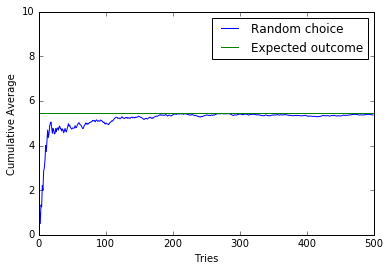

In [297]:
N = 500
tries = range(N)

out_rand = np.zeros(N)
cum_mean_rand =  np.zeros(N)

for k in tries:
    action = int(np.floor(n*random.random()))
    out_rand[k] = outcome(p_actions[action])
    cum_mean_rand[k] = np.mean(out_rand[:k])
    
plt.figure()
plt.plot(tries, cum_mean_rand)
plt.plot(tries, np.mean(p_actions)*np.ones(N)*10)
plt.xlabel('Tries')
plt.ylabel('Cumulative Average')
plt.ylim([0,10])
plt.legend(['Random choice','Expected outcome'])
plt.show()

Now, I'll write a basic algorithm that selects the best action based on previous outcomes. To make sure my algorithm doesn't focus in on a single action based on too few results, I'll include random action choices. I can set the number of actions to chose randomly using the eps parameter. Here, I try different values form 2% to 20% of actions to be chosen at random. I'll need to keep track of the average outcome for each action. It's important to note here that the outcomes will be impacted by chance, and a single test of each eps value isn't enough to determine which is actually the best. I'll average the results for 10 runs of each eps value.

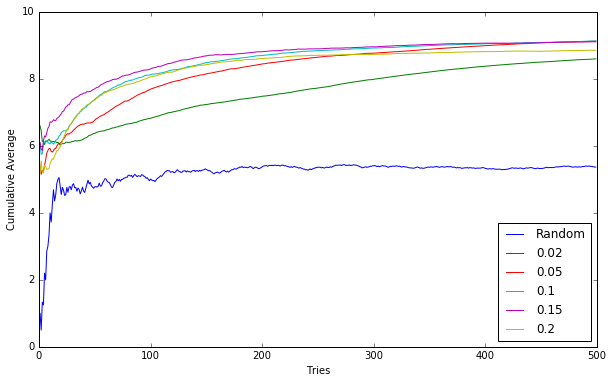

In [332]:
eps_list = [0.02, 0.05, 0.1, 0.15, 0.2]
plt.figure(figsize = [10,6])
plt.plot(tries,cum_mean_rand)
leg = ['Random']
for l in eps_list:
    leg.append(l)
    
end_val_learn = 0
for eps in eps_list:
    cum_mean_av = np.zeros(N)
    for a in range(10):
        out = np.zeros(N)
        cum_mean =  np.zeros(N)
        average_outcome = np.zeros(n)
        action_count = np.zeros(n)
        for t in tries:
            if random.random() < eps:
                action = int(np.floor(10*random.random()))   
            else:
                action = np.argmax(average_outcome)
            out[t] = outcome(p_actions[action])
            old_avg = average_outcome[action]
            action_count[action]+=1
            count = action_count[action]
            if count == 1:
                new_avg = out[t]
            else:
                new_avg = old_avg+(1.0/count)*(out[t]-old_avg)
            average_outcome[action] = new_avg
            cum_mean[t] = np.mean(out[:t])
        cum_mean_av+=cum_mean
        if eps == 0.1:
            end_val_learn += cum_mean[-1]
    plt.plot(tries, cum_mean_av/10.0)
    if eps == 0.1:
        cum_mean_learn = cum_mean
        action_count_learn = action_count

    
end_val_learn = end_val_learn/10.0
plt.legend(leg, loc = 'best')
plt.ylim([0,10])
plt.xlabel('Tries')
plt.ylabel('Cumulative Average')
plt.show()

While having some random choice helps with the learning process, once I know enough about the different action outcomes, I don't want to keep choosing the ones I know to be bad. One way to possibly improve the algorithm is to use a softmax function. Using softmax selection, I can decide which option to choose based on a distribution of the options, weighted by the current best options. The probability of hoosing each option is proportional to its current ranking (in this case, the average) based on results so far.

Here, I've chosen a value of 1.3 for the tau parameter. Instead of plotting the average results for different taus, I plot instead the results for 10 iterations with the same tau value to show the variability of outcomes, even using the identical algorithm.

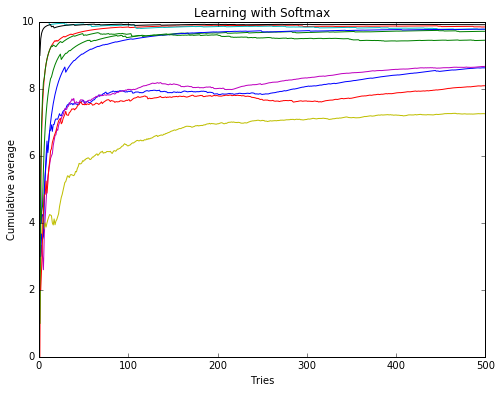

In [325]:
tau = 1.3
sm_cum_mean =  np.zeros([N, 10])
sm_out = np.zeros([N, 10])
end_val_sfm = 0

plt.figure(figsize = [8,6])

for n_tau in range(10):

    def softmax(av):
        probs = np.zeros(n)
        for i in range(n):
            softmax = (np.exp(av[i]/tau)/np.sum(np.exp(av[:]/tau)))
            probs[i] = softmax
        return probs

    sm_counts = np.zeros(n)
    sm_average = np.zeros(n)
    av_softmax = np.zeros(n)
    av_softmax[:] = 1.0/n

    for t in tries:
        action = np.where(p_actions == np.random.choice(p_actions, p = av_softmax))[0][0]
        sm_out[t, n_tau] = outcome(p_actions[action])
        old_avg = sm_average[action]
        sm_counts[action]+=1
        count = sm_counts[action]
        if count == 1:
            new_avg = sm_out[t, n_tau]
        else:
            new_avg = old_avg+(1.0/count)*(sm_out[t, n_tau]-old_avg)
        sm_average[action] = new_avg    
        sm_cum_mean[t,n_tau] = np.mean(sm_out[:t, n_tau])
        av_softmax = softmax(sm_average)

    end_val_sfm = end_val_sfm + sm_cum_mean[-1, n_tau]
    plt.plot(tries,sm_cum_mean[:,n_tau])
    
action_count_sfm = sm_counts
end_val_sfm = end_val_sfm/10.0

plt.title('Learning with Softmax')
plt.xlabel('Tries')
plt.ylabel('Cumulative average')
plt.ylim([0,10])
plt.show()
    

Sometimes, the initial results are not a very good indication of the actual behavior of the system, and so the best option can get missed. I can also design an algorithm that samples each outcome a set number of times to gather information before using the softmax function to select actions. Here, I made an algorithm that tries each action twice before applying softmax. You can see that the outcome becomes much more stable.

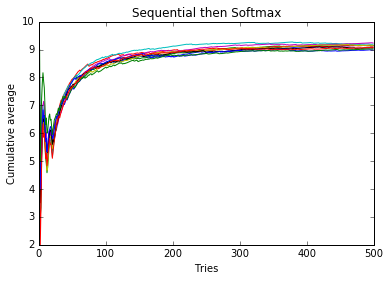

In [330]:
tau = 1.3
end_val_seq_sfm = 0

def softmax(av):
    probs = np.zeros(n)
    for i in range(n):
        softmax = (np.exp(av[i]/tau)/np.sum(np.exp(av[:]/tau)))
        probs[i] = softmax
    return probs

for i in range(10):
    mod_cum_mean =  np.zeros(N)
    mod_out = np.zeros(N)
    mod_counts = np.zeros(n)
    mod_average = np.zeros(n)
    av_softmax = np.zeros(n)
    av_softmax[:] = 1.0/n
  
    for t in tries:
        if t < 20:
            action = t%10
        else:
            action = np.where(p_actions == np.random.choice(p_actions, p = av_softmax))[0][0]
        mod_out[t] = outcome(p_actions[action])
        old_avg = mod_average[action]
        mod_counts[action]+=1
        count = mod_counts[action]
        if count == 1:
            new_avg = mod_out[t]
        else:
            new_avg = old_avg+(1.0/count)*(mod_out[t]-old_avg)
        mod_average[action] = new_avg    
        mod_cum_mean[t] = np.mean(mod_out[:t])
        av_softmax = softmax(mod_average)


    plt.plot(tries,mod_cum_mean)
    end_val_seq_sfm += mod_cum_mean[-1]
    
end_val_seq_sfm = end_val_seq_sfm/10.0
    
plt.title('Sequential then Softmax')
plt.xlabel('Tries')
plt.ylabel('Cumulative average')
plt.show()
    

Now, I'll compare the average outcome for N tries, averaged over 10 runs of each algorithm.

In [340]:
end_val_rand = np.mean(p_actions)*10
print('For %i tries, the average cumulative outcome for each method:' %N)
print('Average with random only: %0.2f' %end_val_rand)
print('Average with learning, 10 perc. random choice: %0.2f' %end_val_learn)
print('Average with softmax, tau = 1.3: %0.2f' %end_val_sfm)
print('Average with 20 sequential then softmax: %0.2f' %end_val_seq_sfm)




For 500 tries, the average cumulative outcome for each method:
Average with random only: 5.46
Average with learning, 10 perc. random choice: 9.14
Average with softmax, tau = 1.3: 9.12
Average with 20 sequential then softmax: 9.11


Another way to compare the algorithms is to compare the distribution of action choices. First, I show the true distribution of expeted outcomes for each action. Below, I show how often each action was chosen by a single run of the 3 algorithms described above (not averaged, note that the distribution could change considerably with each run).

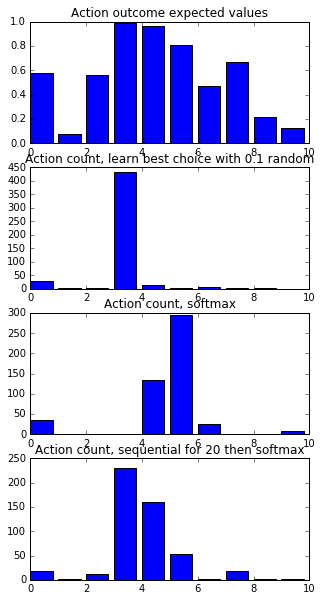

In [341]:

plt.figure(figsize=[5,10])
plt.subplot(411)
plt.bar(range(n),p_actions)
plt.title('Action outcome expected values')
plt.subplot(412)
plt.bar(range(n),action_count_learn)
plt.title('Action count, learn best choice with 0.1 random')
plt.subplot(413)
plt.bar(range(n), action_count_sfm)
plt.title('Action count, softmax')
plt.subplot(414)
plt.bar(range(n),mod_counts)
plt.title('Action count, sequential for 20 then softmax')
plt.show()
